# Linear, Lasso & Ridge Regression

In [1]:
import warnings
import itertools

# Install gitpath below if not already available on your environment.
#! pip install git+https://github.com/maxnoe/python-gitpath
import gitpath

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

## Importing our Dataset

In [2]:
#Getting the file path for the data file.
file_path = str(gitpath.root()) + '/data/no_nans_data.xlsx'

In [3]:
df = pd.read_excel(file_path)
df['Contract Years Left'] = df['Contract Years Left'].apply(lambda x:int(x))

In [4]:
df

,Player,Club,Age,Position,Nation,Value,Contract Years Left,League,MP (20/21),Starts (20/21),...,Offsides (17/18),Crosses (17/18),Interceptions (17/18),Penalty Kicks Won (17/18),Penalties Conceded (17/18),Own Goals (17/18),Total Loose Balls Recovered (17/18),Aerial Duel Won (17/18),Aerial Duel Lost (17/18),% Aerial Duels Won (17/18)
0,Kylian Mbappe,Paris Saint-Germain,22,attack,France,144000000,1,Ligue 1,31.0,27.0,...,23.0,62.0,1.0,1.0,0.0,0.0,98.0,1.0,4.0,20.0
1,Erling Haaland,Borussia Dortmund,21,attack,Norway,117000000,3,Bundesliga,28.0,27.0,...,9.0,8.5,5.0,0.5,0.0,0.0,70.0,29.0,31.5,47.9
2,Harry Kane,Tottenham Hotspur,28,attack,England,108000000,3,Premier League,35.0,35.0,...,43.0,24.0,7.0,1.0,0.0,0.0,124.0,69.0,111.0,38.3
3,Jadon Sancho,Manchester United,21,attack,England,90000000,5,Premier League,26.0,24.0,...,1.0,15.0,6.0,0.0,0.0,0.0,57.0,3.0,14.0,17.6
4,Mohamed Salah,Liverpool FC,29,attack,Egypt,90000000,2,Premier League,37.0,34.0,...,18.0,50.0,13.0,1.0,0.0,0.0,219.0,19.0,58.0,24.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,Phil Bardsley,Burnley FC,36,Defender,Scotland,270000,1,Premier League,4.0,3.0,...,0.0,20.0,24.0,0.0,1.0,0.0,141.0,27.0,32.0,45.8
1721,Luca Siligardi,Parma Calcio 1913,33,attack,Italy,270000,1,Serie A,20.5,11.0,...,1.0,21.5,11.5,1.0,0.0,0.0,81.5,10.5,14.0,50.2
1722,Mikel Rico,SD Huesca,36,midfield,Spain,270000,1,La Liga,32.0,27.0,...,0.0,7.0,17.0,0.0,0.0,0.0,156.0,2.0,7.0,22.2
1723,Jerome Hergault,FC Lorient,35,Defender,France,270000,1,Ligue 1,22.0,19.0,...,5.0,29.0,25.0,0.0,0.0,0.0,131.0,25.0,25.0,50.0


## Splitting data into 3 Positions

In [5]:
attack = df[df['Position']=='attack']
midfield = df[df['Position']=='midfield']
defence = df[df['Position']=='Defender']

position_list = [attack,midfield,defence]

## Linear Regression

In [6]:
#Initiating a results Dataframe
lr_results = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
a=1

for position in position_list:

    #Finding top 10 correlated features
    top_features = list((abs(position.corr()['Value'])).sort_values(ascending=False)[1:11].keys())

    #Separating target variable - 'Value'. Only top 10 features are included in X.
    X = position[top_features]
    y = position['Value']

    #Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    ############################################################################

    #Making the distribution of the features more Gaussian

    pt = PowerTransformer()

    X_train_transformed = pt.fit_transform(X_train)
    X_test_transformed = pt.transform(X_test)

    ############################################################################

    #Scaling the data

    #Initiating Robust Scaler
    rs= RobustScaler()

    #Standardizing numerical columns
    X_train_scaled = rs.fit_transform(X_train_transformed)
    X_test_scaled = rs.transform(X_test_transformed)

    ############################################################################

    #Initiating the Linear Regressor
    lr = LinearRegression()

    #Fitting the Linear Regressor with Training Data
    lr.fit(X_train_scaled,y_train);

    ############################################################################

    cross_val_train = cross_val_score(lr, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
    cross_val_test = cross_val_score(lr, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

    ############################################################################

    #Train Results
    cross_val_train_mean = round(-(cross_val_train.mean()),2)
    cross_val_train_max = round(-(cross_val_train.min()),2)
    cross_val_train_min = round(-(cross_val_train.max()),2)

    #Test Results
    cross_val_test_mean = round(-(cross_val_test.mean()),2)
    cross_val_test_max = round(-(cross_val_test.min()),2)
    cross_val_test_min = round(-(cross_val_test.max()),2)

    #Appending Results to Dataframe and making Visuals
    
    if a == 1: 
        lr_results.loc[0] = ['Attack Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        lr_results.loc[1] = ['Attack Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    if a == 2: 
        lr_results.loc[2] = ['Midfield Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        lr_results.loc[3] = ['Midfield Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]
        
    if a == 3: 
        lr_results.loc[4] = ['Defend Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        lr_results.loc[5] = ['Defend Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    a+=1

### Comparing Linear Regression Results between Attack, Midfield and Defence

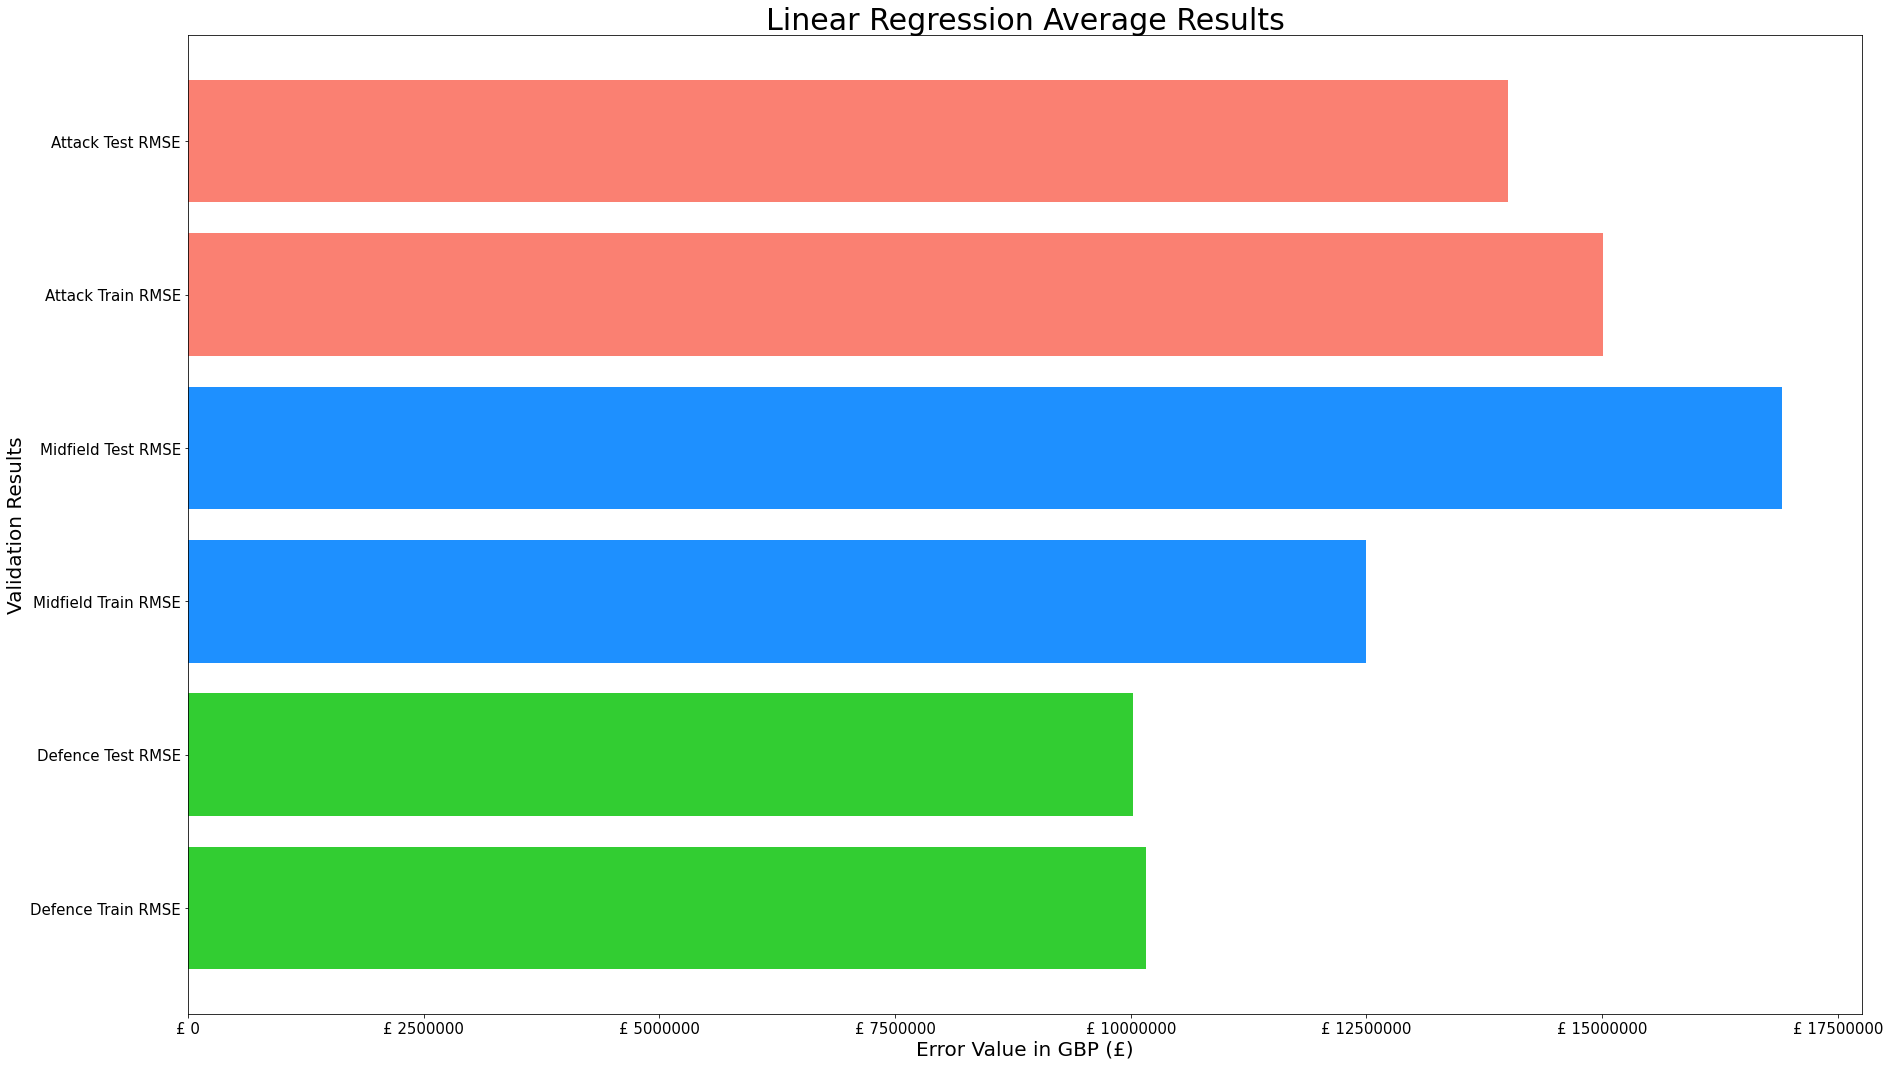

In [7]:
fig, ax = plt.subplots(figsize=(30,18))

x_ticks = list(range(0,int((max(lr_results['Avg RMSE']))+1000000),2500000))
y_ticks = [1,2,3,4,5,6]
y_labels = ['Defence Train RMSE','Defence Test RMSE',
            'Midfield Train RMSE','Midfield Test RMSE',
            'Attack Train RMSE','Attack Test RMSE',]

#Defence Results
def_train_pos = 1
def_train = lr_results['Avg RMSE'][4]
ax.barh(def_train_pos,def_train,color='limegreen')

def_test_pos = 2
def_test = lr_results['Avg RMSE'][5]
ax.barh(def_test_pos,def_test,color='limegreen')

#Midfield Results
mid_train_pos = 3
mid_train = lr_results['Avg RMSE'][2]
ax.barh(mid_train_pos,mid_train,color='dodgerblue')

mid_test_pos = 4
mid_test = lr_results['Avg RMSE'][3]
ax.barh(mid_test_pos,mid_test,color='dodgerblue')

#Attack Results
att_train_pos = 5
att_train = lr_results['Avg RMSE'][0]
ax.barh(att_train_pos,att_train,color='salmon')

att_test_pos = 6
att_test = lr_results['Avg RMSE'][1]
ax.barh(att_test_pos,att_test,color='salmon')


#Labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontsize=15)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks],fontsize=15)
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Linear Regression Average Results',fontsize=30);

### Cross Validation Results- Linear Regression

In [8]:
lr_results

,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Attack Train,15005176.37,18323857.57,12265100.76
1,Attack Test,13996397.72,20258600.35,10787266.09
2,Midfield Train,12494010.90,13566500.55,10713910.28
3,Midfield Test,16909509.38,20811251.42,13376037.11
4,Defend Train,10160727.85,12860865.25,8957755.18
5,Defend Test,10027544.14,18770840.91,6654565.28


## Lasso Regression

In [9]:
#Initiating a results Dataframe
l1_results = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
a=1
warnings.filterwarnings("ignore")
for position in position_list:

    #Finding top 10 correlated features
    top_features = list((abs(position.corr()['Value'])).sort_values(ascending=False)[1:11].keys())

    #Separating target variable - 'Value'. Only top 10 features are included in X.
    X = position[top_features]
    y = position['Value']

    #Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    ############################################################################

    #Making the distribution of the features more Gaussian

    pt = PowerTransformer()

    X_train_transformed = pt.fit_transform(X_train)
    X_test_transformed = pt.transform(X_test)

    ############################################################################

    #Scaling the data

    #Initiating Robust Scaler
    rs= RobustScaler()

    #Standardizing numerical columns
    X_train_scaled = rs.fit_transform(X_train_transformed)
    X_test_scaled = rs.transform(X_test_transformed)

    ############################################################################

    #Initiating the Linear Regressor
    l1 = Lasso()

    #Fitting the Linear Regressor with Training Data
    l1.fit(X_train_scaled,y_train);

    ############################################################################

    cross_val_train = cross_val_score(l1, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
    cross_val_test = cross_val_score(l1, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

    ############################################################################

    #Train Results
    cross_val_train_mean = round(-(cross_val_train.mean()),2)
    cross_val_train_max = round(-(cross_val_train.min()),2)
    cross_val_train_min = round(-(cross_val_train.max()),2)

    #Test Results
    cross_val_test_mean = round(-(cross_val_test.mean()),2)
    cross_val_test_max = round(-(cross_val_test.min()),2)
    cross_val_test_min = round(-(cross_val_test.max()),2)

    #Appending Results to Dataframe and making Visuals
    
    if a == 1: 
        l1_results.loc[0] = ['Attack Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l1_results.loc[1] = ['Attack Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    if a == 2: 
        l1_results.loc[2] = ['Midfield Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l1_results.loc[3] = ['Midfield Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]
        
    if a == 3: 
        l1_results.loc[4] = ['Defend Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l1_results.loc[5] = ['Defend Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    a+=1

### Comparing Lasso Regression Results between Attack, Midfield and Defence

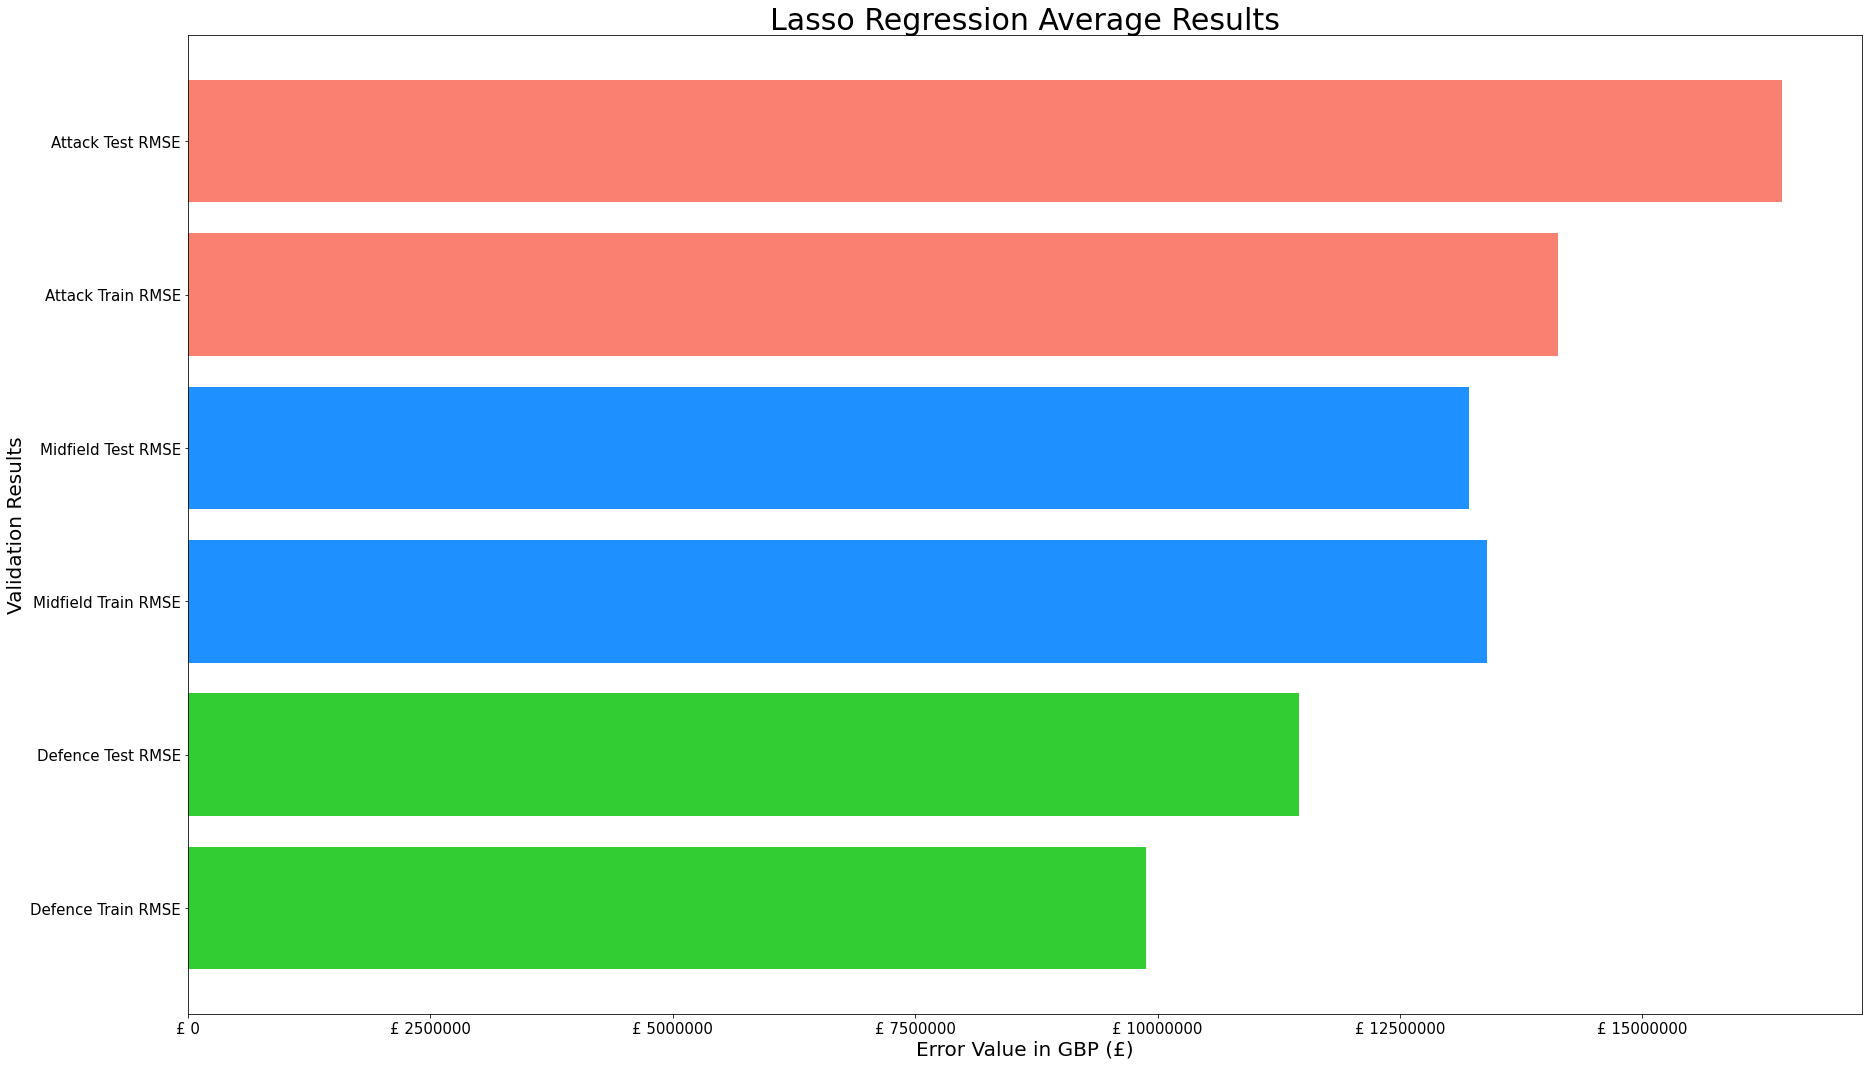

In [10]:
fig, ax = plt.subplots(figsize=(30,18))

x_ticks = list(range(0,int((max(l1_results['Avg RMSE']))+1000000),2500000))
y_ticks = [1,2,3,4,5,6]
y_labels = ['Defence Train RMSE','Defence Test RMSE',
            'Midfield Train RMSE','Midfield Test RMSE',
            'Attack Train RMSE','Attack Test RMSE',]

#Defence Results
def_train_pos = 1
def_train = l1_results['Avg RMSE'][4]
ax.barh(def_train_pos,def_train,color='limegreen')

def_test_pos = 2
def_test = l1_results['Avg RMSE'][5]
ax.barh(def_test_pos,def_test,color='limegreen')

#Midfield Results
mid_train_pos = 3
mid_train = l1_results['Avg RMSE'][2]
ax.barh(mid_train_pos,mid_train,color='dodgerblue')

mid_test_pos = 4
mid_test = l1_results['Avg RMSE'][3]
ax.barh(mid_test_pos,mid_test,color='dodgerblue')

#Attack Results
att_train_pos = 5
att_train = l1_results['Avg RMSE'][0]
ax.barh(att_train_pos,att_train,color='salmon')

att_test_pos = 6
att_test = l1_results['Avg RMSE'][1]
ax.barh(att_test_pos,att_test,color='salmon')


#Labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontsize=15)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks],fontsize=15)
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Lasso Regression Average Results',fontsize=30);

### Cross Validation Results- Lasso Regression

In [11]:
l1_results

,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Attack Train,14134122.48,19619830.01,10517853.89
1,Attack Test,16441726.52,21560654.33,12390234.77
2,Midfield Train,13399363.43,14784859.64,11820138.31
3,Midfield Test,13215631.17,17534827.72,8169214.62
4,Defend Train,9881088.64,11114281.76,8433106.69
5,Defend Test,11460855.97,14114326.82,7480115.43


## Ridge Regression

In [12]:
#Initiating a results Dataframe
l2_results = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
a=1
warnings.filterwarnings("ignore")
for position in position_list:

    #Finding top 10 correlated features
    top_features = list((abs(position.corr()['Value'])).sort_values(ascending=False)[1:11].keys())

    #Separating target variable - 'Value'. Only top 10 features are included in X.
    X = position[top_features]
    y = position['Value']

    #Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    ############################################################################

    #Making the distribution of the features more Gaussian

    pt = PowerTransformer()

    X_train_transformed = pt.fit_transform(X_train)
    X_test_transformed = pt.transform(X_test)

    ############################################################################

    #Scaling the data

    #Initiating Robust Scaler
    rs= RobustScaler()

    #Standardizing numerical columns
    X_train_scaled = rs.fit_transform(X_train_transformed)
    X_test_scaled = rs.transform(X_test_transformed)

    ############################################################################

    #Initiating the Linear Regressor
    l2 = Ridge()

    #Fitting the Linear Regressor with Training Data
    l2.fit(X_train_scaled,y_train);

    ############################################################################

    cross_val_train = cross_val_score(l2, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
    cross_val_test = cross_val_score(l2, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

    ############################################################################

    #Train Results
    cross_val_train_mean = round(-(cross_val_train.mean()),2)
    cross_val_train_max = round(-(cross_val_train.min()),2)
    cross_val_train_min = round(-(cross_val_train.max()),2)

    #Test Results
    cross_val_test_mean = round(-(cross_val_test.mean()),2)
    cross_val_test_max = round(-(cross_val_test.min()),2)
    cross_val_test_min = round(-(cross_val_test.max()),2)

    #Appending Results to Dataframe and making Visuals
    
    if a == 1: 
        l2_results.loc[0] = ['Attack Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l2_results.loc[1] = ['Attack Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    if a == 2: 
        l2_results.loc[2] = ['Midfield Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l2_results.loc[3] = ['Midfield Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]
        
    if a == 3: 
        l2_results.loc[4] = ['Defend Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l2_results.loc[5] = ['Defend Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    a+=1

### Comparing Ridge Regression Results between Attack, Midfield and Defence

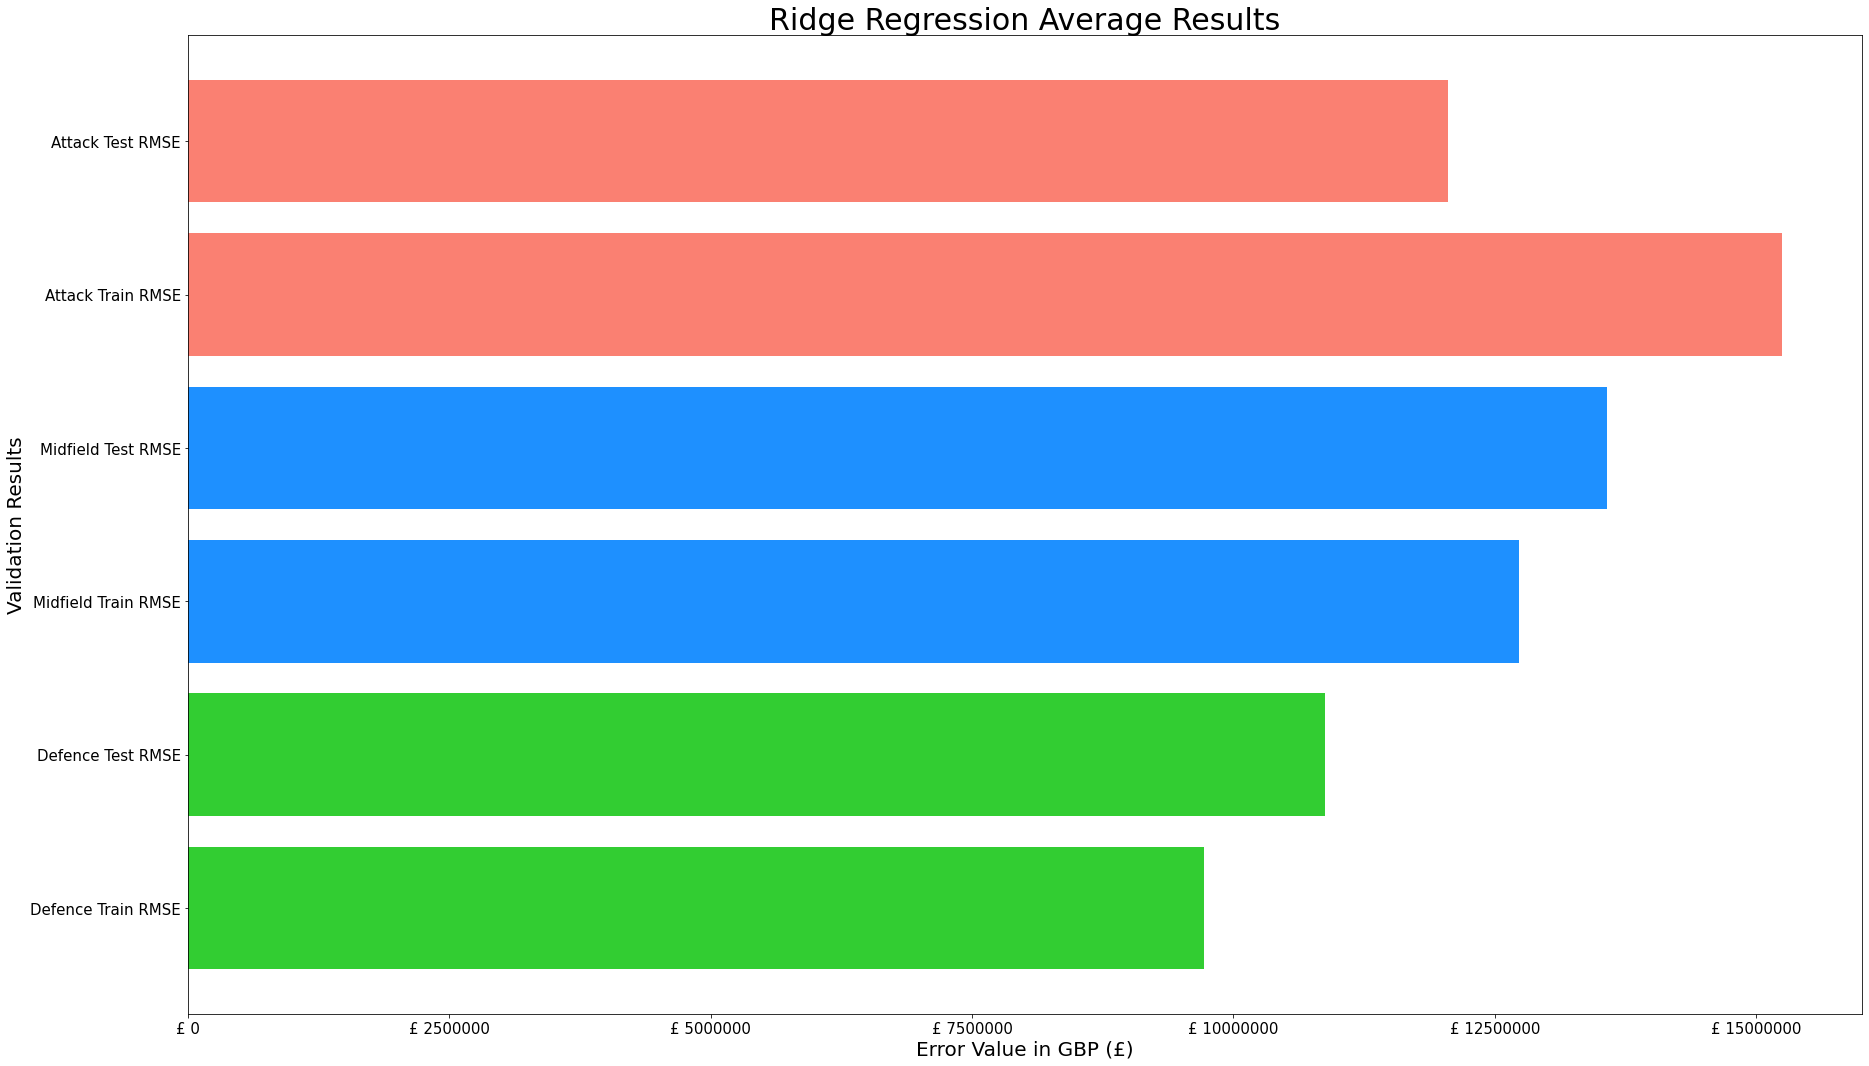

In [13]:
fig, ax = plt.subplots(figsize=(30,18))

x_ticks = list(range(0,int((max(l2_results['Avg RMSE']))+1000000),2500000))
y_ticks = [1,2,3,4,5,6]
y_labels = ['Defence Train RMSE','Defence Test RMSE',
            'Midfield Train RMSE','Midfield Test RMSE',
            'Attack Train RMSE','Attack Test RMSE',]

#Defence Results
def_train_pos = 1
def_train = l2_results['Avg RMSE'][4]
ax.barh(def_train_pos,def_train,color='limegreen')

def_test_pos = 2
def_test = l2_results['Avg RMSE'][5]
ax.barh(def_test_pos,def_test,color='limegreen')

#Midfield Results
mid_train_pos = 3
mid_train = l2_results['Avg RMSE'][2]
ax.barh(mid_train_pos,mid_train,color='dodgerblue')

mid_test_pos = 4
mid_test = l2_results['Avg RMSE'][3]
ax.barh(mid_test_pos,mid_test,color='dodgerblue')

#Attack Results
att_train_pos = 5
att_train = l2_results['Avg RMSE'][0]
ax.barh(att_train_pos,att_train,color='salmon')

att_test_pos = 6
att_test = l2_results['Avg RMSE'][1]
ax.barh(att_test_pos,att_test,color='salmon')


#Labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontsize=15)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks],fontsize=15)
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Ridge Regression Average Results',fontsize=30);

### Cross Validation Results- Ridge Regression

In [14]:
l2_results

,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Attack Train,15249248.00,18061013.01,13077655.48
1,Attack Test,12055883.60,19130412.92,8123015.72
2,Midfield Train,12726953.37,15641791.90,10516431.61
3,Midfield Test,13572709.96,21252143.82,8275480.45
4,Defend Train,9714115.96,11143178.59,7469105.26
5,Defend Test,10880051.20,13375925.55,8698459.50


## Final Evaluation of all Linear, Lasso & Ridge Regressors

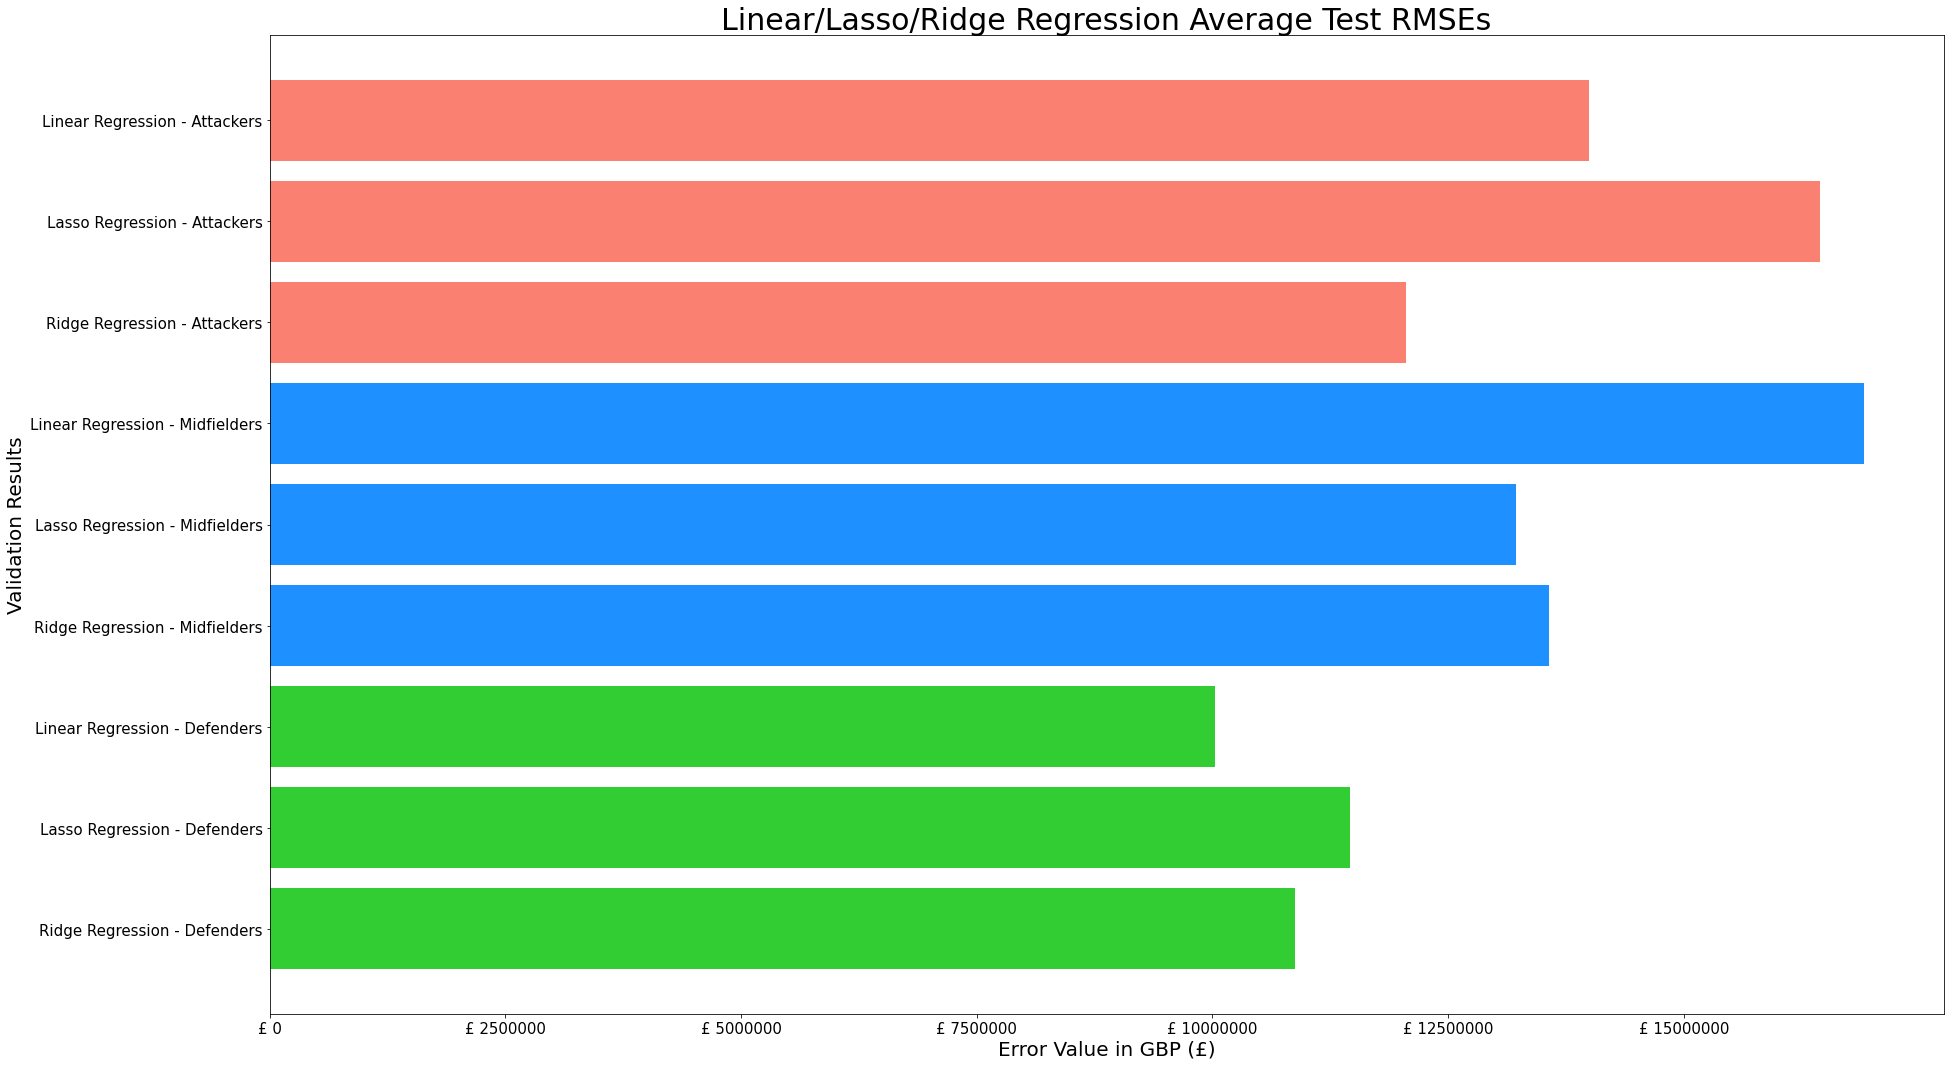

In [15]:
fig, ax = plt.subplots(figsize=(30,18))

x_ticks = list(range(0,int((max(l2_results['Avg RMSE']))+1000000),2500000))
y_ticks = list(range(1,10))
y_labels = ['Ridge Regression - Defenders',
            'Lasso Regression - Defenders',
            'Linear Regression - Defenders',
            'Ridge Regression - Midfielders',
            'Lasso Regression - Midfielders', 
            'Linear Regression - Midfielders',
            'Ridge Regression - Attackers',
            'Lasso Regression - Attackers',
            'Linear Regression - Attackers']

#Defence Results
l2_def_test_pos = 1
l2_def_test = l2_results['Avg RMSE'][5]
ax.barh(l2_def_test_pos,l2_def_test,color='limegreen')

l1_def_test_pos = 2
l1_def_test = l1_results['Avg RMSE'][5]
ax.barh(l1_def_test_pos,l1_def_test,color='limegreen')

lr_def_test_pos = 3
lr_def_test = lr_results['Avg RMSE'][5]
ax.barh(lr_def_test_pos,lr_def_test,color='limegreen')

#Midfield Results
l2_mid_test_pos = 4
l2_mid_test = l2_results['Avg RMSE'][3]
ax.barh(l2_mid_test_pos,l2_mid_test,color='dodgerblue')

l1_mid_test_pos = 5
l1_mid_test = l1_results['Avg RMSE'][3]
ax.barh(l1_mid_test_pos,l1_mid_test,color='dodgerblue')

lr_mid_test_pos = 6
lr_mid_test = lr_results['Avg RMSE'][3]
ax.barh(lr_mid_test_pos,lr_mid_test,color='dodgerblue')

#Attack Results

l2_att_test_pos = 7
l2_att_test = l2_results['Avg RMSE'][1]
ax.barh(l2_att_test_pos,l2_att_test,color='salmon')

l1_att_test_pos = 8
l1_att_test = l1_results['Avg RMSE'][1]
ax.barh(l1_att_test_pos,l1_att_test,color='salmon')

lr_att_test_pos = 9
lr_att_test = lr_results['Avg RMSE'][1]
ax.barh(lr_att_test_pos,lr_att_test,color='salmon')

#Labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontsize=15)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks],fontsize=15)
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Linear/Lasso/Ridge Regression Average Test RMSEs',fontsize=30);